## Devil image box count demo

#### Contents
1. Define some functions to help us work with the Devil images:
2. Point to the location of the input data on the filesystem
3. Run a demo to show how we can
    1. detect all tumours from a single image
    2. define and draw some boxes onto the image
    3. count tumours that intersect these boxes
4. Run the above on all the inputs and make a summary plot and counts

In [4]:
# Imports all libraries needed and defines all functions and classes
import pathlib
from collections import Counter
import cv2
import numpy as np
import scipy.ndimage
from matplotlib.gridspec import GridSpec
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt

class Box:
    """
    Represents a box added to the face plot.
    Can draw on top of an image (add_to_axis) and can detect
    tumours that fall inside the box (get_tumours_in_box).
    Can also count the number of pixels inside the box for
    each tumour (get_tumour_pixel_count_in_box).
    """
    def __init__(self, topleft: (int, int), width: int, height: int):
        """
        Constructor: topleft is a pair of coordinates (x, y) giving the
        position of the top-left corner of the box, where x is "number of
        pixels away from the left edge of the image" and y is "number of
        pixels down from the top edge of the image".
        width is the horizontal size of the box in pixels.
        height is the vertical size of the box in pixels.
        """
        self.topleft = topleft
        self.width = width
        self.height = height
    
    def add_to_axis(self, axis: matplotlib.axes.Axes):
        """
        Draws the box on top of the image in the axis.
        """
        rect = patches.Rectangle(
            self.topleft, self.width, self.height,
            linewidth=1, edgecolor='red', facecolor='none')  # Red box, no fill
        axis.add_patch(rect)

    def get_tumours_in_box(self, labelled):
        """
        Gets the label numbers of the tumours that intersect this box. Returns a set.
        """
        left = self.topleft[0]
        right = left + self.width
        top = self.topleft[1]
        bottom = top + self.height
        labels_in_box = set(int(lab) for lab in labelled[top:bottom, left:right].ravel())
        if 0 in labels_in_box:
            labels_in_box.remove(0)
        return labels_in_box

    def get_tumour_pixel_count_in_box(self, labelled):
        """
        Gets the label number of the tumours intersecting this box, and the
        size of the intersection in pixels. Returns a Counter (dictionary).
        """
        left = self.topleft[0]
        right = left + self.width
        top = self.topleft[1]
        bottom = top + self.height
        labels_in_box = Counter(int(lab) for lab in labelled[top:bottom, left:right].ravel())
        labels_in_box.pop(0, 0)
        return labels_in_box

def ref_extract(filename, cut_point=200):
    """
    Young Mi's function to read the reference image and add transparency
    Added 'cut_point' to control the sharpness of the resulting image -
    lower cut points mean more of the background gets converted to transparency,
    but the foreground gets washed out; higher cut points retain more foreground,
    but more of the background fails to be made transparent. Values around 128-200
    work well.
    """
    ref_bgr = cv2.imread(ref_filename)
    ref_bw = cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(ref_bw, cut_point, 255, cv2.THRESH_BINARY_INV)
    b, g, r = cv2.split(ref_bgr)
    bgra = [b, g, r, alpha]
    dst = cv2.merge(bgra, 4)
    return cv2.cvtColor(dst, cv2.COLOR_BGRA2RGBA)

def load_hsv_image(filename):
    """
    Loads an image from a file. Returns an array of pixel data in HSV format.
    """
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def hsv_to_mask(hsv):
    """
    Searches the HSV pixel array for blue regions (blue represents tumour).
    Returns an array where False means background and True means blue.
    """
    light_blue = (110, 150, 100)
    dark_blue = (130, 255, 255)
    mask = cv2.inRange(hsv, light_blue, dark_blue)
    return mask

def classify_mask(mask, filter_less_than=50, verbose=False):
    """
    Numbers each connected component of blue pixels. Removes very tiny
    groups (by default anything smaller than 50 pixels - `filter_less_than`).
    Input: mask array created by hsv_to_mask
    Output: labels array of equal size to mask, containing integer values for
    each pixel - 0=background (no tumour), 1..n=the nth distinct tumour
    """
    labels, num_features = scipy.ndimage.label(mask)
    if verbose:
        print(f'There are {num_features} features before filtering')
    mask_copy = mask.copy()
    pixel_counts = np.bincount(labels.ravel())
    for i in range(len(pixel_counts)):
        if pixel_counts[i] < filter_less_than:
            mask_copy[labels == i] = False
    labels, num_features = scipy.ndimage.label(mask_copy)
    if verbose:
        print(f'There are {num_features} features after filtering')
    return labels

def tumour_sizes_in_pixels(labels):
    pixel_counts = Counter(labels.ravel())
    _ = pixel_counts.pop(0, 0)
    return pixel_counts

def get_filepaths(indir):
    """
    Searches indir for files matching '*.jpg' or '*.jpeg'
    """
    return [filepath
            for filepath in pathlib.Path(indir).iterdir()
            if filepath.is_file()
                and filepath.suffix in {'.jpg', '.jpeg'}]
    
def read_input_folder(indir, boxes):
    """
    Reads all files in a folder, aggregates their images and counts
    tumours inside boxes
    """
    filepaths = get_filepaths(indir)
    box_counts = [0 for _ in range(len(boxes))]
    dns = []
    for fl in filepaths:
        img = load_hsv_image(fl)
        msk = hsv_to_mask(img)
        if msk.shape != (500, 500):
            print(fl, msk.shape)
        dns.append(msk / 255)
        lab = classify_mask(msk)
        for i in range(len(boxes)):
            box_counts[i] += len(boxes[i].get_tumours_in_box(lab))
    tumour_density = np.asarray(dns).sum(axis=0)
    return box_counts, tumour_density

In [38]:
# Defines locations of files we need to work on
indir = "/Users/rebeccascott/Library/CloudStorage/OneDrive-UniversityofCambridge/VETERINARY MEDICINE-Rebecca’s MacBook Air copy/Project/Devil Face Maps/DFT1/Female/Front Face"
ref_filename='/Users/rebeccascott/Desktop/devil_ref.jpg'
devil_ref = ref_extract(ref_filename)

Box 1 contains tumours set()
Box 2 contains tumours set()


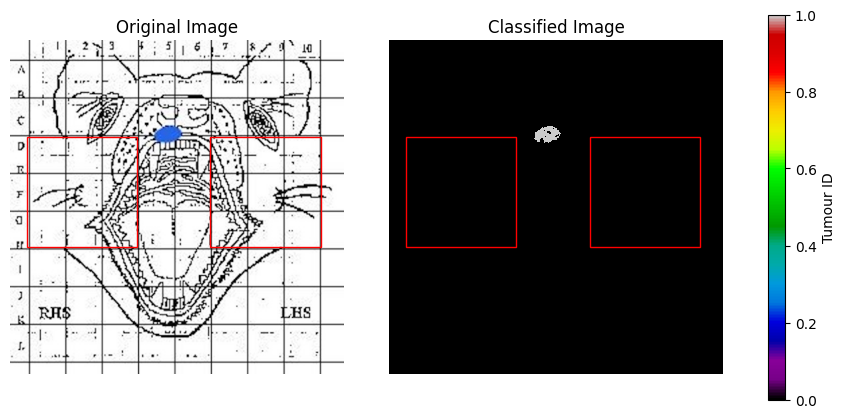

In [39]:
# An example to check that we can read an image and identify all distinct tumours,
# and then create some counting boxes and use them to count how many tumours fall
# into each box.

# Select an example file
filepaths = get_filepaths(indir)
fl = filepaths[3]

# Load the image and classify its tumours
img = load_hsv_image(fl)
msk = hsv_to_mask(img)
lab = classify_mask(msk, filter_less_than=50, verbose=False)

# Define some boxes - we'll see them in red on the plots below
boxes = [Box(topleft=(25,      145), width=165, height=165),
         Box(topleft=(300, 145), width=165, height=165),]

# Find the tumours inside each box and print them out
for i, box in enumerate(boxes, start=1):
    print(f'Box {i} contains tumours {box.get_tumours_in_box(lab)}')

# All the rest of the code in this cell is plotting code
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # Ensure equal widths, extra space for colorbar

# Draw the first panel - the original image
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
ax1.set_title("Original Image")
ax1.axis("off")

# Draw the second panel - just the extracted tumours
ax2 = fig.add_subplot(gs[0, 1])
im = ax2.imshow(lab, cmap='nipy_spectral', interpolation='nearest')
ax2.set_title("Classified Image")
ax2.axis("off")

# Draw the boxes on top of each picture
for ax in [ax1, ax2]:
    for box in boxes:
        box.add_to_axis(ax)

# Draw the colour bar that IDs each classified tumour
cax = fig.add_subplot(gs[0, 2])
fig.colorbar(im, cax=cax, label="Tumour ID")
plt.show()

Total Box counts = [67, 86]


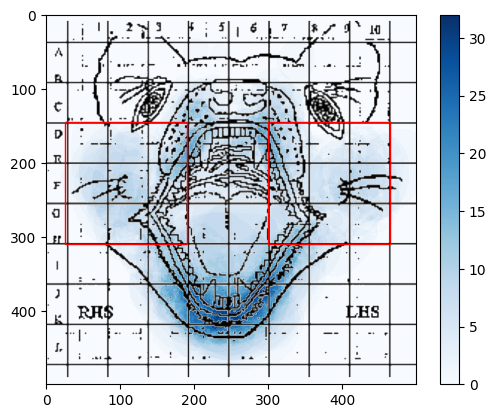

In [40]:
# An example to read all input files and summarise them. The box counts are saved in variable `box_counts`, and
# `density` contains the stacked tumour image data.
# 1: Reads all jpgs and jpegs in input folder and collects total tumour counts in each box and overall tumour density
# 2: Plots the density, overlays the transparent face image, and adds a scale bar

# 1
box_counts, density = read_input_folder(indir, boxes)
print(f'Total Box counts = {box_counts}')

# 2
fig, ax = plt.subplots()
im = ax.imshow(density, cmap = 'Blues', interpolation='nearest')
fig.colorbar(im)
ax.imshow(devil_ref)
for box in boxes:
    box.add_to_axis(ax)
plt.show()

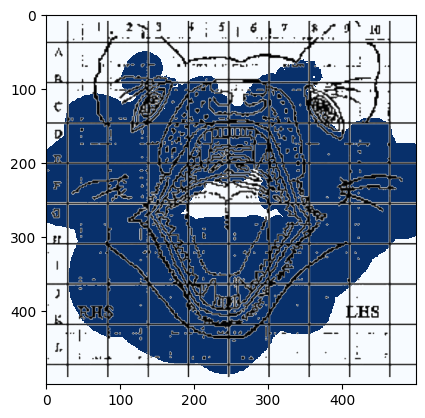

In [99]:
# BONUS CONTENT
# About the plot where all tumours get plotted dark blue regardless of density, I think something like this
# should work:

# 1 - Compress the tumour density to either 0 or 1 (make a copy to not overwrite the original density)
dens_copy = np.copy(density)
dens_copy[dens_copy > 0] = 1

# 2 - Plot the compressed data
fig, ax = plt.subplots()
im = ax.imshow(dens_copy, cmap = 'Blues', interpolation='nearest')
ax.imshow(devil_ref)
plt.show()